# Top - K Sampling Instruct Finetuning.

## 1. Introduction

High-quality data is fundamental to produce a good model in any field. The higher the quality, the better the model. In this notebook, we will create a dataset for finetuning LLM's

![](https://i.imgur.com/IDNhAWH.png)

There are different types of datasets we can use to fine-tune LLMs:

1. **Instruction datasets**: inputs are instructions (e.g., questions) and outputs correspond to the expected responses (e.g., answers). *Example: [Open-Orca](https://huggingface.co/datasets/Open-Orca/OpenOrca).*
2. **Raw completion**: this is a continuation of the pre-training objective (next token prediction). In this case, the trained model is not designed to be used as an assistant. *Example: [MADLAD-400](https://huggingface.co/datasets/allenai/MADLAD-400).*
3. **Preference datasets**: these datasets are used with reinforcement learning to rank candidate responses. They can provide multiple answers to the same instruction, and help the model to select the best response. *Example: [ultrafeedback_binarized](https://huggingface.co/datasets/HuggingFaceH4/ultrafeedback_binarized).*
4. **Others**: a fill-in-the-middle objective is very popular with code completion models (e.g., Codex from GitHub Copilot). Other datasets can be designed for classification, where the outputs correspond to the labels we want to predict (the model requires an additional classfication head in this case).

In practice, supervised fine-tuning only leverages the first type of dataset. We can either **create our own** instruction dataset or **modify an existing one** to filter, improve, or enrich it.

## 2. Load and analyze the dataset

In this notebook, we will use a Open Platypus dataset such that translated to Turkish [Open-Platypus](https://huggingface.co/datasets/TR-LLMs/Open-Platypus-TR).

In [1]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 27.3 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("TR-LLMs/Open-Platypus-TR")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [3]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,Döndürücünün $C$'a inme olasılığını bulmak içi...,"Bir masa oyunu döndürücüsü $A$, $B$ ve $C$ eti...",MATEMATİK/PRM-800K
1,,14 kişiden 6'sını seçmem gerekiyor ve sıra öne...,Okulumun matematik kulübünde 6 erkek ve 8 kız ...,MATEMATİK/PRM-800K
2,,Öncelikle kelime sınırlaması olmaksızın 4 harf...,"$A$, $B$, $C$, $D$ ve $E$ harflerinden en az b...",MATEMATİK/PRM-800K
3,,Bunu ancak ve ancak zarlardan en az birinin 1'...,Melinda iki standart altı yüzlü zar atacak ve ...,MATEMATİK/PRM-800K
4,,Problemi H ve T'lerin dizisi olarak düşünün. A...,"Adil bir parayı tekrar tekrar atma sürecinde, ...",MATEMATİK/PRM-800K
...,...,...,...,...
24921,,Tüm asal sayıları üreten çeşitli formüller var...,Tüm asal sayıları üretecek bir formül bulabili...,guanako
24922,,"Elbette, işte en iyi üniversitelerden bazıları...",Robotik eğitimi almak için en iyi üniversitele...,guanako
24923,,[Soldaki sahneye girin]\n\nBirinci Vatandaş: İ...,Bana kullanıcıdan 2 sayı alan ve bu iki sayını...,guanako
24924,,Bu çok düşünceli bir fikir! Kız arkadaşınız iç...,MERHABA. Görme engelli kız arkadaşım için kaba...,guanako


## 3. Tokenizing

For tokenize our dataset, we will use SOTA (State of the Art) model by Meta [Llama-3](https://huggingface.co/meta-llama/Meta-Llama-3-8B).


tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


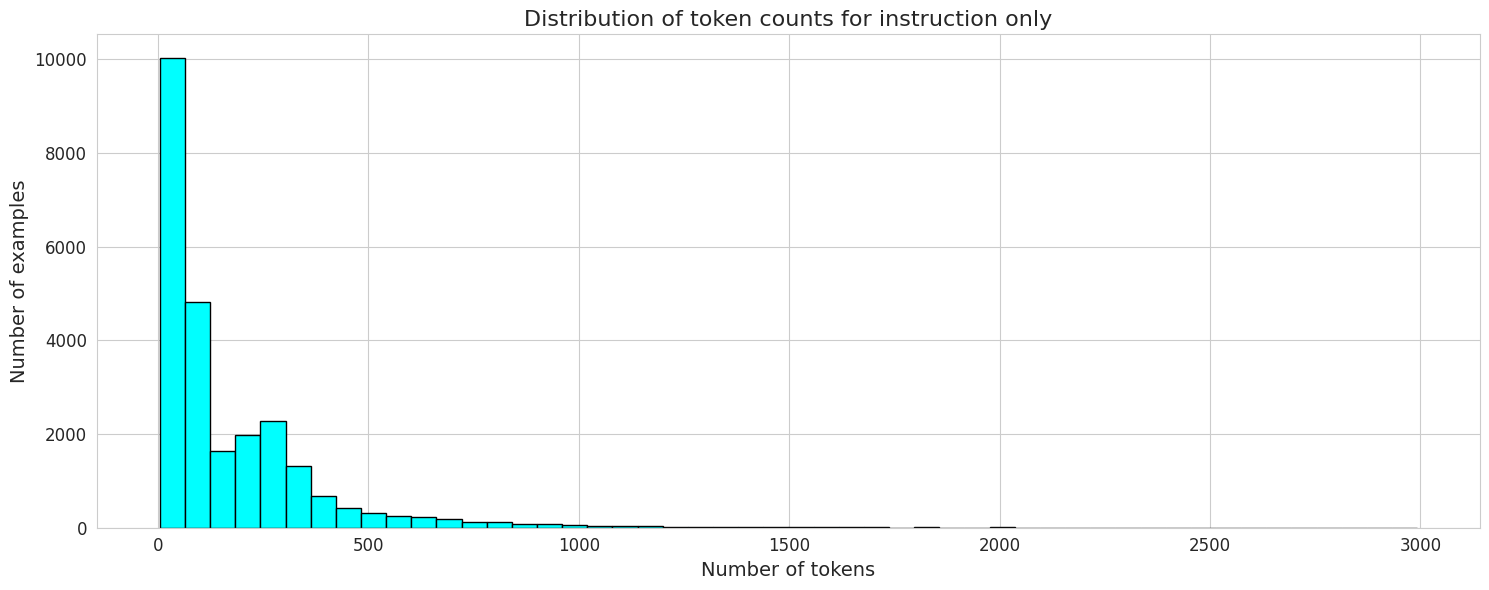

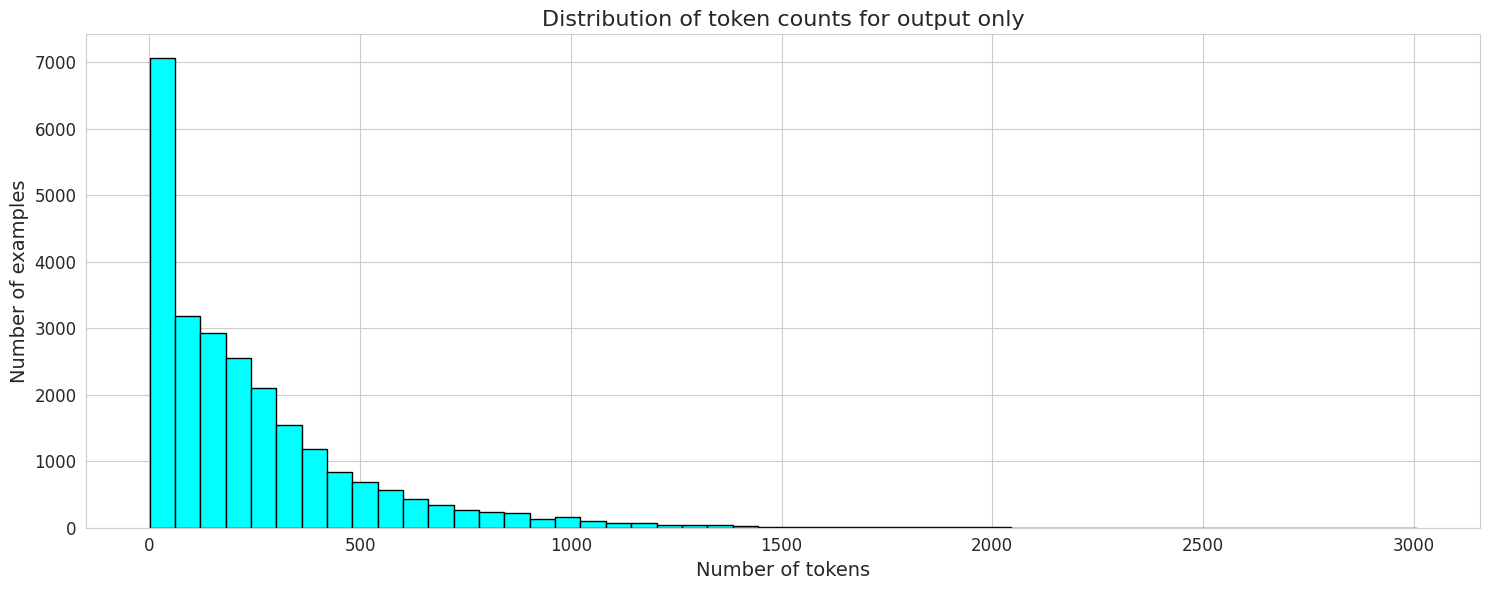

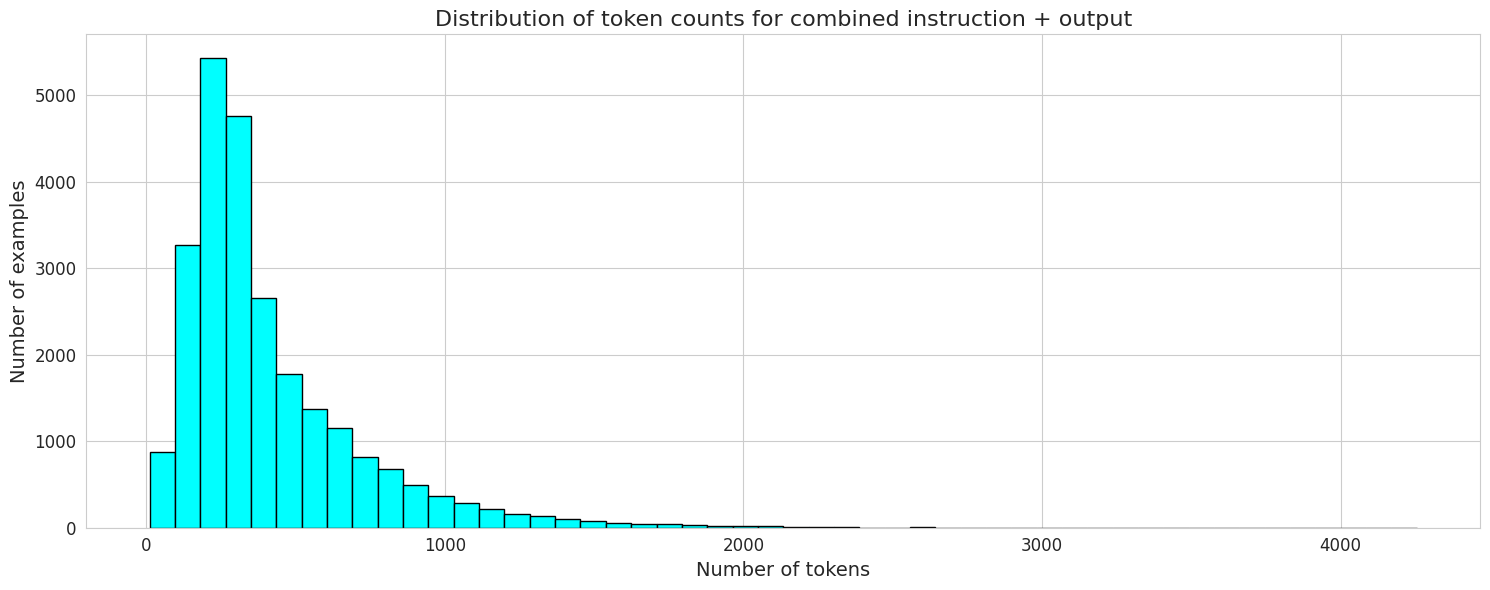

In [4]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Meta-Llama-3-8B")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='cyan', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

As we can see, our data is skewed. This can result in missing data or incorrect answers when we attempt to fine-tune.

## 4. Filter out rows with more than 1024 tokens

To address this issue, we will remove samples with more than 2048 tokens, which aligns with the default maximum context size of Llama 3 (8192 tokens).

Number of valid rows: 23636
Removing 1290 rows...


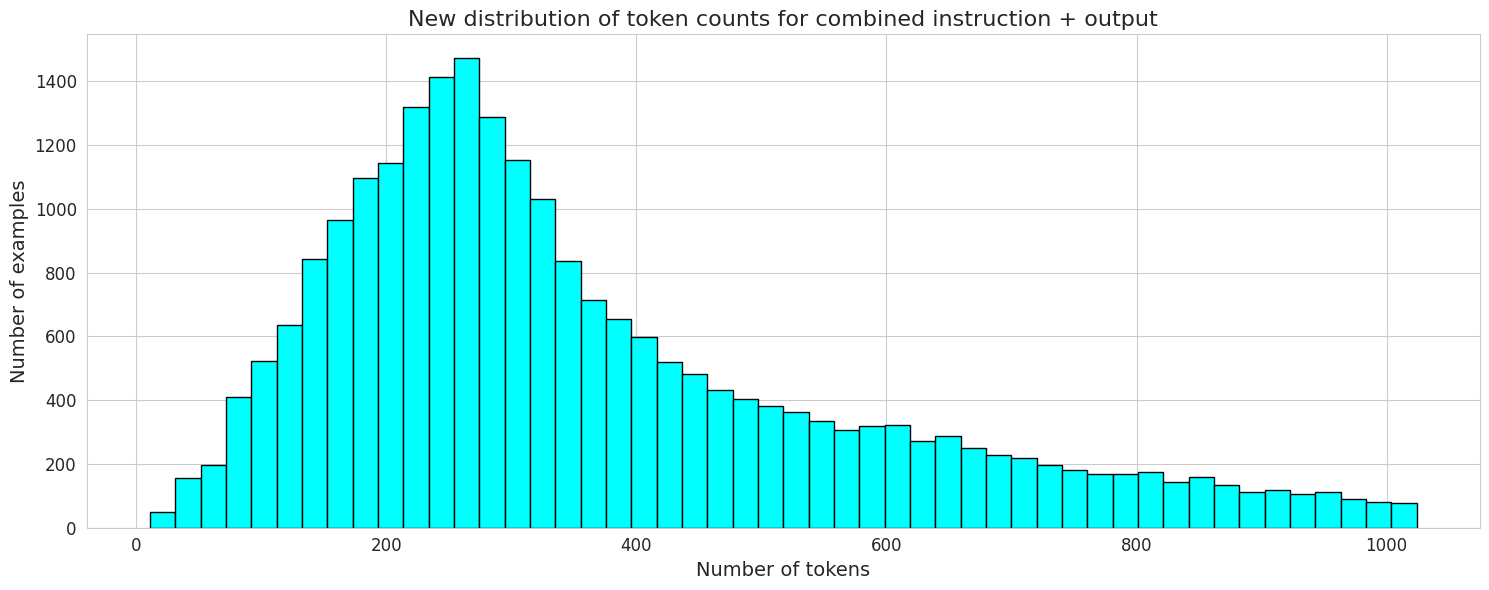

In [5]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 1024]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

## 4. Near-deduplication using embeddings

Algorithm:
 * The function primarily utilizes cosine similarity to determine near-duplicates comparing the cosine similarity between each embedding and its nearest neighbor against a threshold.

$$
\cos (\theta ) =   \dfrac {A \cdot B} {\left\| A\right\| _{2}\left\| B\right\| _{2}}
$$

* While the Faiss library is employed for efficient similarity search, the actual similarity computation relies on cosine similarity rather than k-nearest neighbors.

$$
\ d(\mathbf{p}, \mathbf{q}) = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + \cdots + (q_n - p_n)^2} \
$$

![](https://media.geeksforgeeks.org/wp-content/uploads/20200616145419/Untitled2781.png)



In [6]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["output"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

In [7]:
deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/739 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/23636 [00:00<?, ?it/s]

In [8]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 23636
Number of samples in the deduped dataset: 16731
Number of samples that were removed: 6905


## 5. Top-k sampling

Only keep the top k samples with the most tokens.

In [9]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
        "output": [dataset['train'][i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 500  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

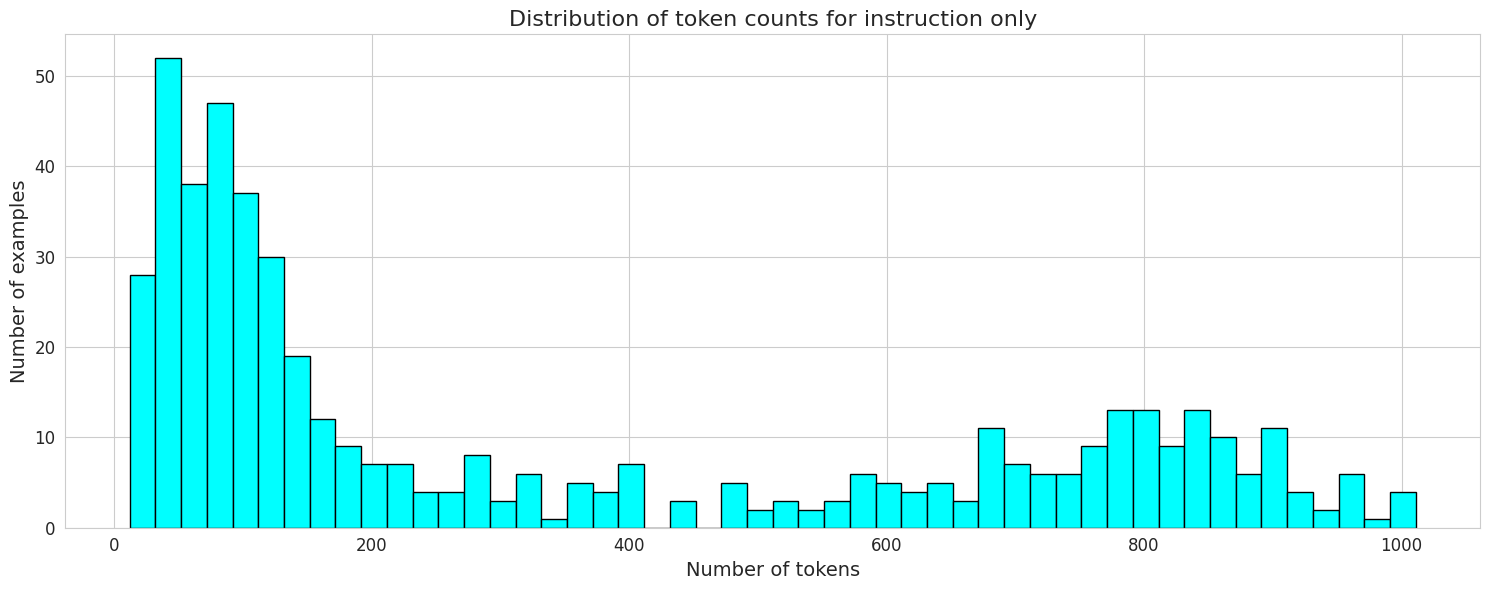

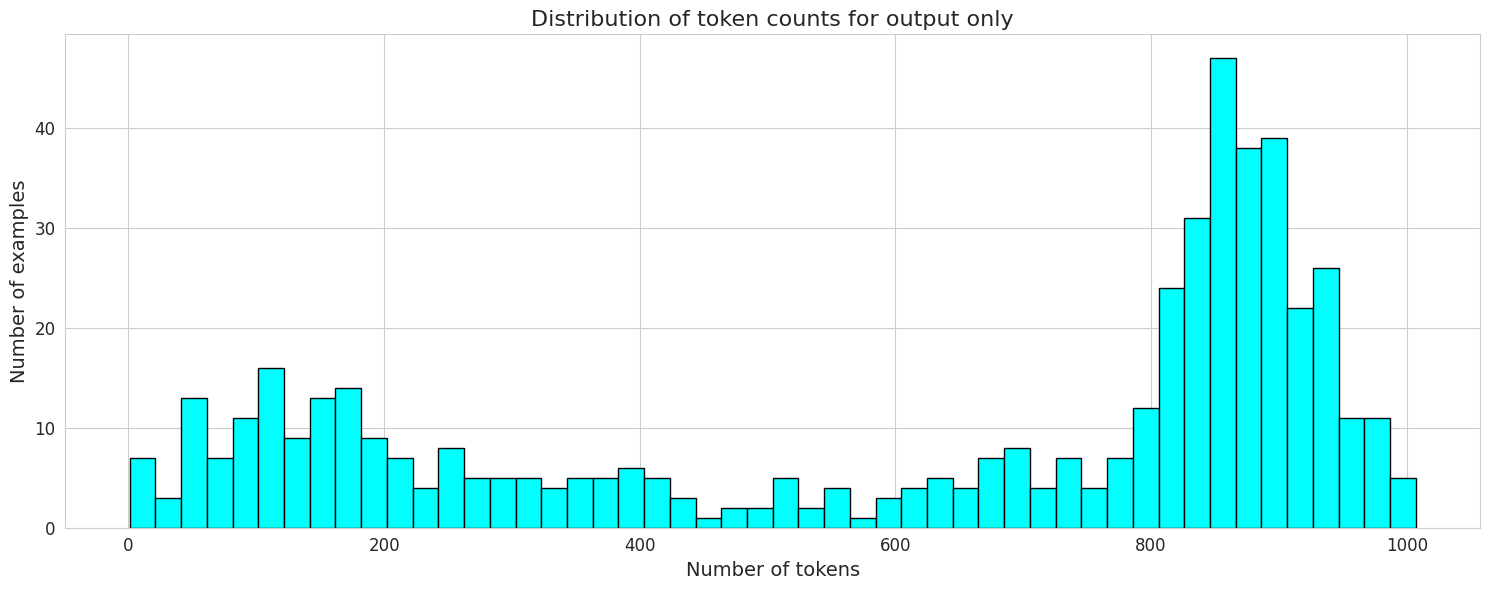

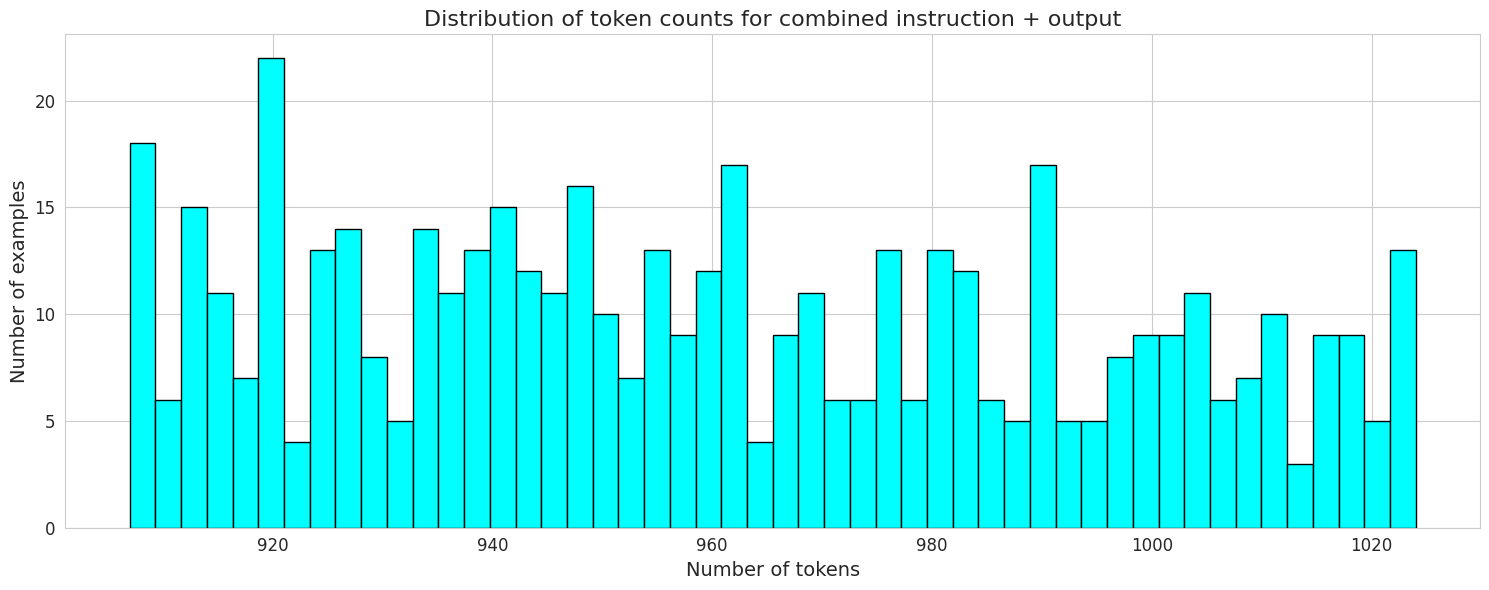

In [10]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")